In [1]:
import warnings
from pathlib import Path

import pandas as pd

from plot_utils import load_metrics, plot_map_per_config

warnings.filterwarnings('ignore', category=UserWarning)

#### Create configs for loading evalzoo results

In [2]:
RESULTS_DIR = Path("../2.evalzoo/results/")
MERTRICS_FILENAME = "metrics_level_1_ref"
FIGSAVE_PATH = Path("output/mAP_visualizations")

METRICS_COLUMNS = {
    "sim_retrieval_average_precision_ref_i_mean_i": "mAP",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i": "-log(pvalue)",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i": "-log(qvalue)",
}

GROUPBY_COLUMNS = {
    "same_well_diff_pert": ["Metadata_Well"],
    "same_pert_diff_well": ["Metadata_JCP2022"],
    "same_well_same_pert": ["Metadata_Well", "Metadata_JCP2022"],
}

GENE_GROUPBY_COLUMNS = {
    "same_well_diff_gene": ["Metadata_Well"],
    "same_gene_diff_well": ["Metadata_Symbol"],
    "same_well_same_gene": ["Metadata_Well", "Metadata_Symbol"],
}

#### List which results to plot

`Note:` in this version, results without cc adjustment (panels 1 and 3) did not unclude CC as a feature, unlike CC-adjusted results (panels 2 and 4)

In [3]:
# All results combined, see https://github.com/alxndrkalinin/position-effect-correction/blob/1d7c0b9ba8e93b7adb81ecc9df70f444a944d43a/3.correct/3_compare_metrics_subset.ipynb

# metrics = {
#     # subset -> robustMAD -> feature select -> metrics
#     "subset->preprocess\t\t\t": {
#         "same_well_diff_pert": "0e4cd68f",
#         "same_pert_diff_well": "ceb5f02a",
#         "same_well_same_pert": "34fbd8a4",
#     },
#     # subset -> well correct -> robustMAD -> feature select -> metrics
#     "subset->well_correct->preprocess\t": {
#         "same_well_diff_pert": "82ad004e",
#         "same_pert_diff_well": "f5c36cb4",
#         "same_well_same_pert": "d66f1bce",
#     },
#     # well correct -> robustMAD -> feature select -> subset -> metrics
#     "well_correct->subset->preprocess\t": {
#         "same_well_diff_pert": "3ec971b2",
#         "same_pert_diff_well": "72f94e10",
#         "same_well_same_pert": "138739c0",
#     },
#     # subset -> robustMAD -> feature select -> cell count correct -> metrics
#     "subset->preprocess->cc_correct\t": {
#         "same_well_diff_pert": "3701ed2c",
#         "same_pert_diff_well": "440d5bda",
#         "same_well_same_pert": "a69994b0",
#     },
#     # subset -> cell count correct -> robustMAD -> feature select -> metrics
#     "subset->cc_correct->preprocess\t": {
#         "same_well_diff_pert": "d2311b58",
#         "same_pert_diff_well": "5f53102a",
#         "same_well_same_pert": "e2bf955d",
#     },
#     # subset -> cell count correct -> well correct -> robustMAD -> feature select -> metrics
#     "subset->cc_correct->well_correct->preprocess\t": {
#         "same_well_diff_pert": "304eb132",
#         "same_pert_diff_well": "1b22d880",
#         "same_well_same_pert": "faa6ba3e",
#     },
# }

#### Individual ORF annotations

In [4]:
orf_metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset->preprocess\t\t\t": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> cell count correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->preprocess\t": {
        "same_well_diff_pert": "d2311b58",
        "same_pert_diff_well": "5f53102a",
        "same_well_same_pert": "e2bf955d",
    },
    # subset -> well correct -> robustMAD -> feature select -> metrics
    "subset->well_correct->preprocess\t": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
    # subset -> cell count correct -> well correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->well_correct->preprocess\t": {
        "same_well_diff_pert": "304eb132",
        "same_pert_diff_well": "1b22d880",
        "same_well_same_pert": "faa6ba3e",
    },
}

#### Gene symbol annotations

In [5]:

gene_metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset->preprocess\t\t\t": {
        "same_well_diff_gene": "5ee8aabb",
        "same_gene_diff_well": "26efacc8",
        "same_well_same_gene": "758dee96",
    },
    # subset -> cell count correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->preprocess\t": {
        "same_well_diff_gene": "889ca0ab",
        "same_gene_diff_well": "790b8557",
        "same_well_same_gene": "5a048fe4",
    },
    # subset -> well correct -> robustMAD -> feature select -> metrics
    "subset->well_correct->preprocess\t": {
        "same_well_diff_gene": "c4c7aa12",
        "same_gene_diff_well": "ef524325",
        "same_well_same_gene": "61da8ae0",
    },
    # subset -> cell count correct -> well correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->well_correct->preprocess\t": {
        "same_well_diff_gene": "b8ad0e58",
        "same_gene_diff_well": "6fae5285",
        "same_well_same_gene": "b3ded838",
    },
}

#### Load evalzoo metrics

In [6]:
orf_metrics_df = load_metrics(orf_metrics, METRICS_COLUMNS, GROUPBY_COLUMNS, RESULTS_DIR, MERTRICS_FILENAME)
print(orf_metrics_df.shape)

gene_metrics_df = load_metrics(gene_metrics, METRICS_COLUMNS, GENE_GROUPBY_COLUMNS, RESULTS_DIR, MERTRICS_FILENAME)
print(gene_metrics_df.shape)

(16232, 8)
(17136, 8)


#### Plot mAP scatterplots and densities

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


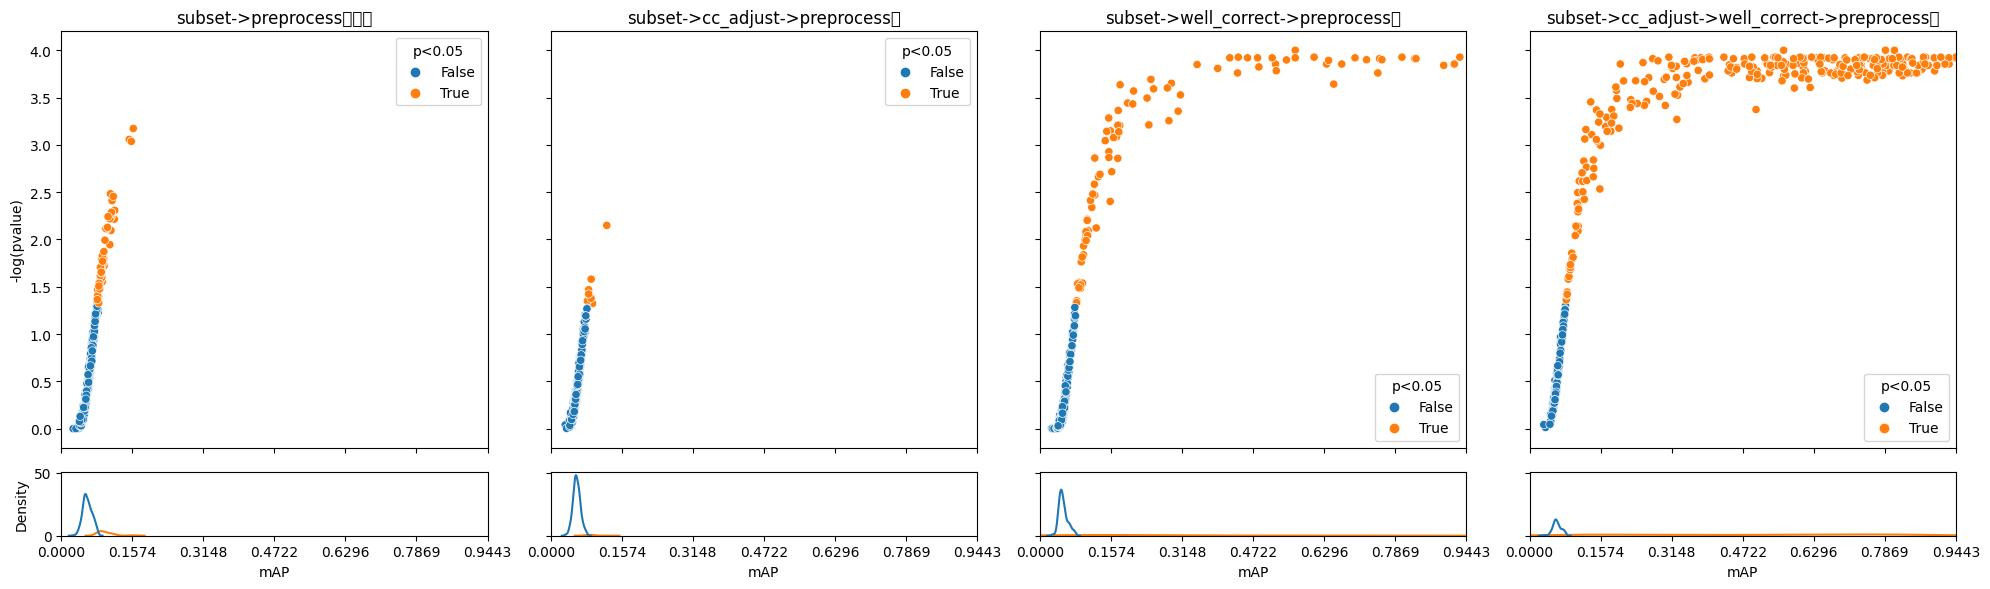

same_pert_diff_well subset->preprocess			 mmAP: 0.00974 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0202 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0166 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00834 p<0.05: 0.0 (0/37)


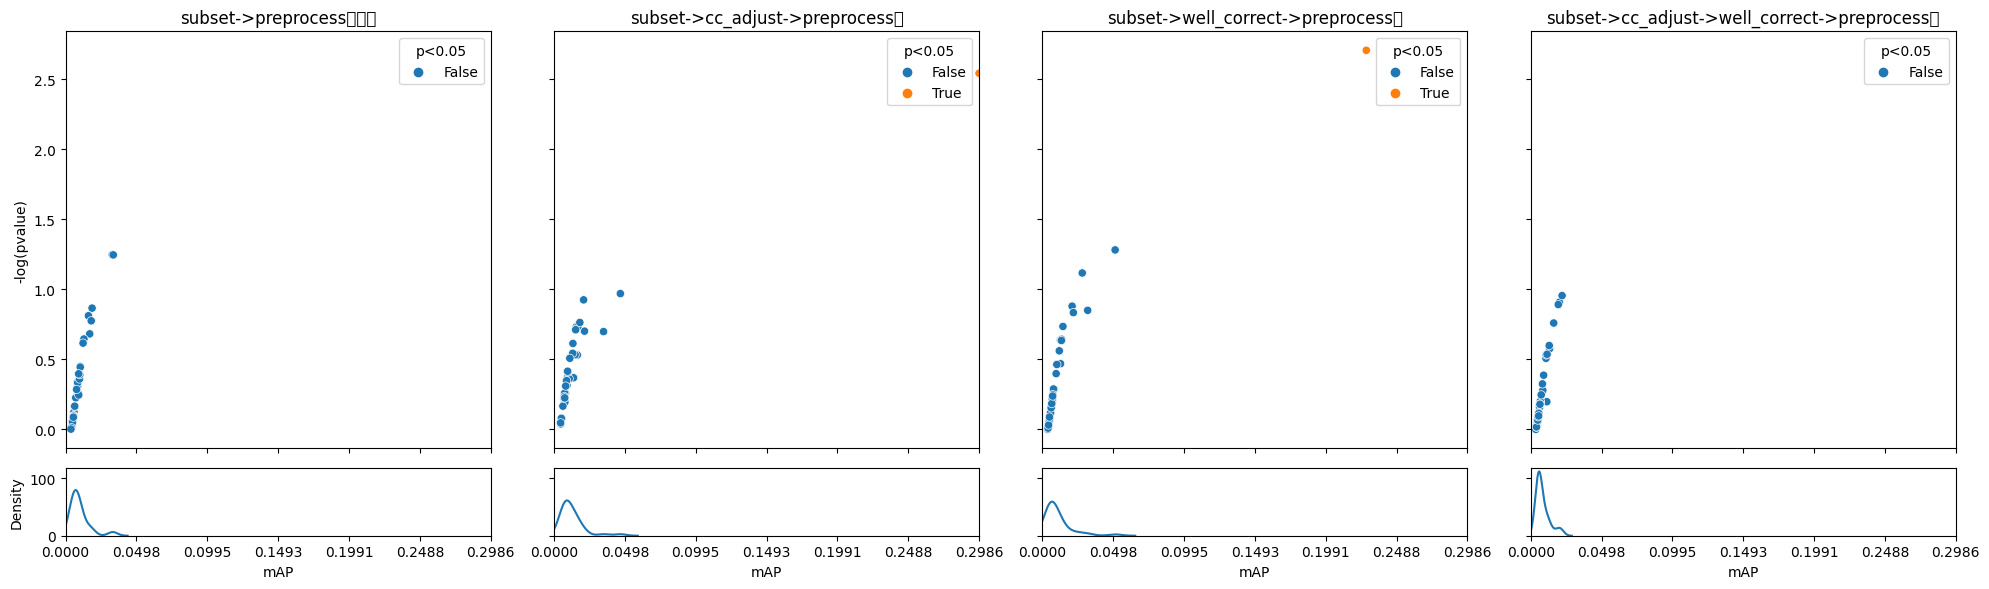

same_well_same_pert subset->preprocess			 mmAP: 0.195 p<0.05: 0.903 (3297/3653)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0856 p<0.05: 0.417 (1524/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.286 p<0.05: 0.93 (3397/3653)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.538 p<0.05: 0.989 (3612/3653)


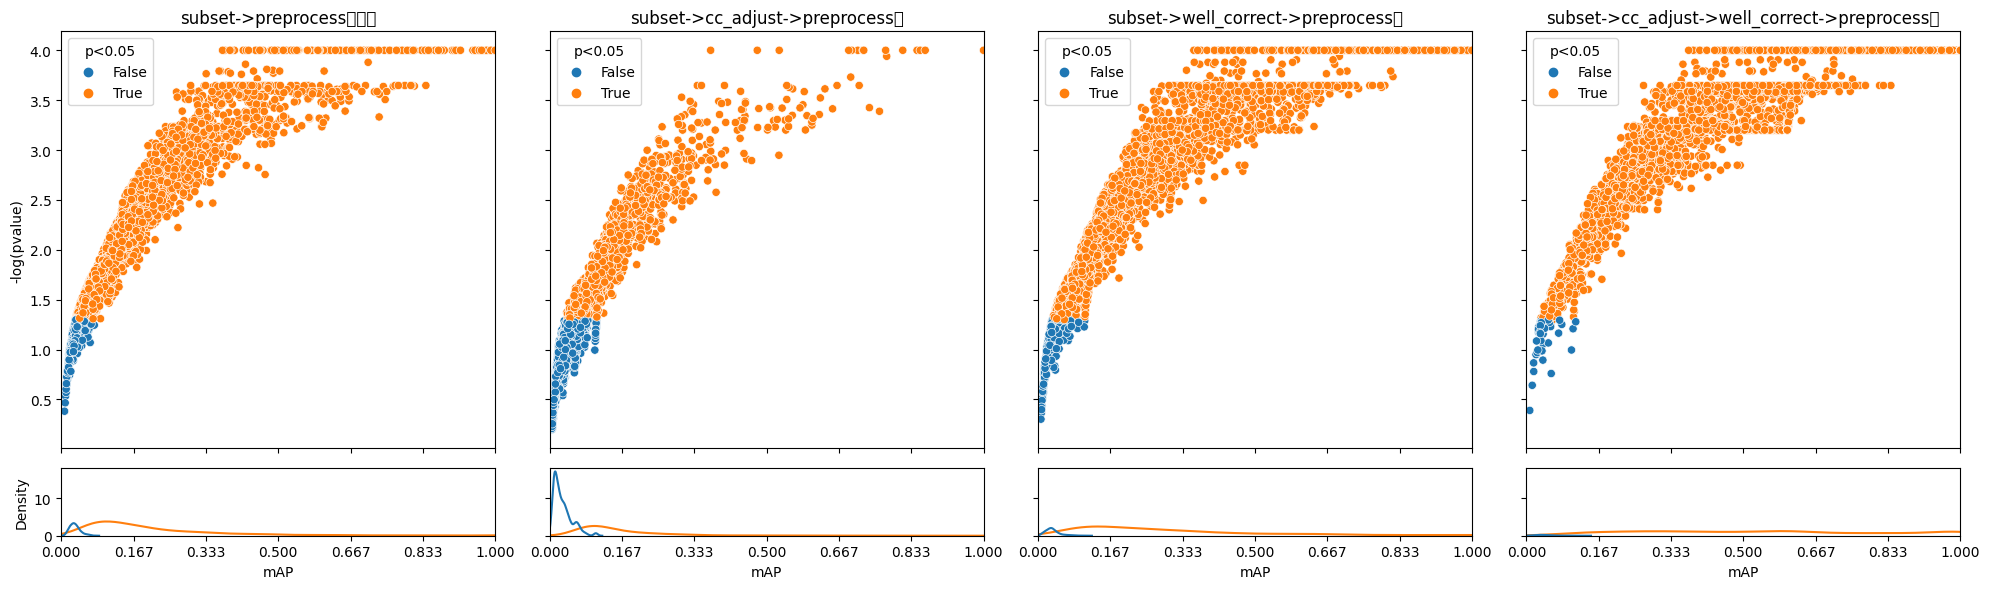

same_well_diff_gene subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_gene subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_gene subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_gene subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


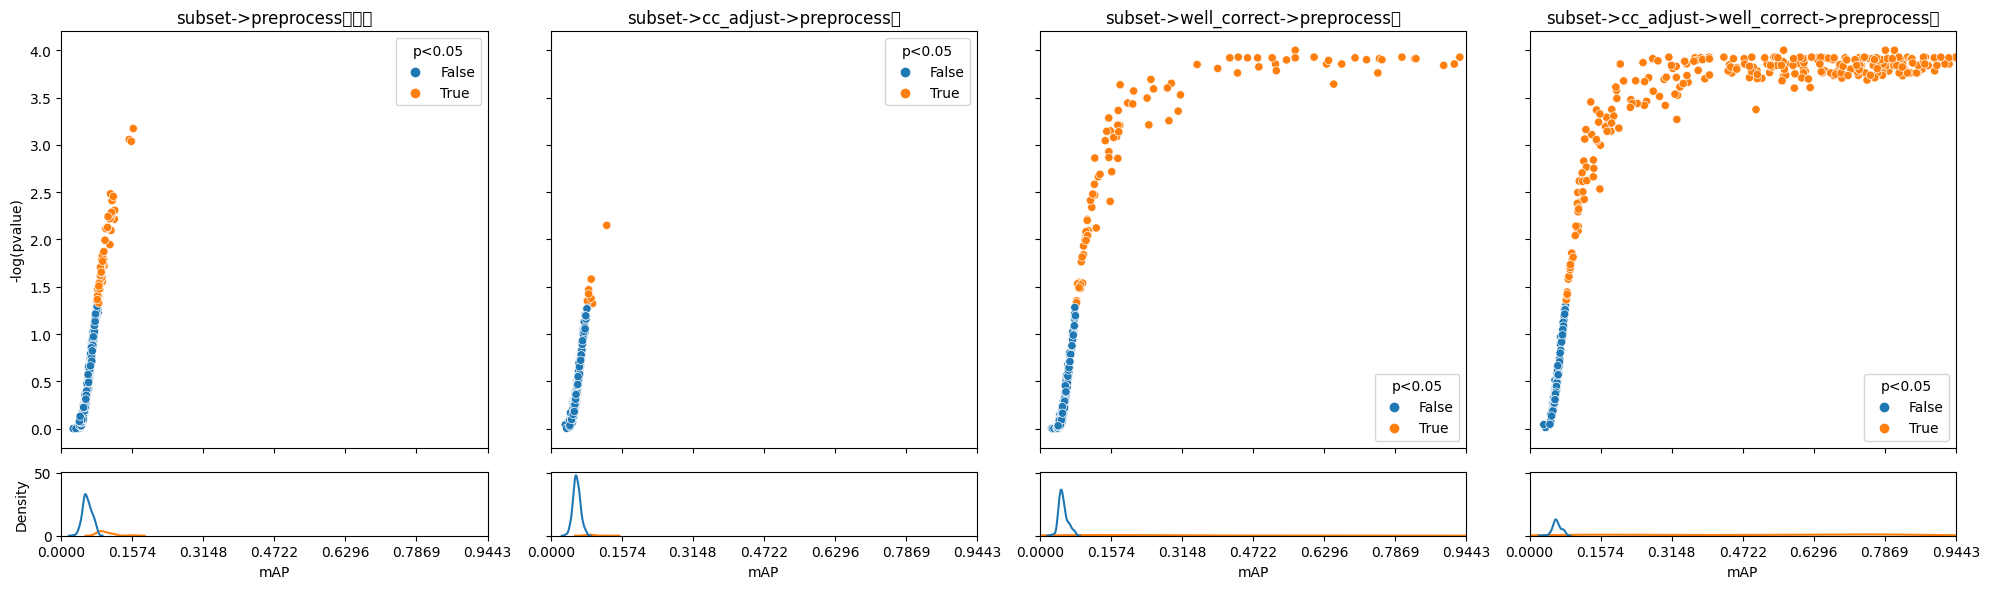

same_gene_diff_well subset->preprocess			 mmAP: 0.0415 p<0.05: 0.273 (72/264)
same_gene_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0262 p<0.05: 0.121 (32/264)
same_gene_diff_well subset->well_correct->preprocess	 mmAP: 0.0367 p<0.05: 0.284 (75/264)
same_gene_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.0278 p<0.05: 0.152 (40/264)


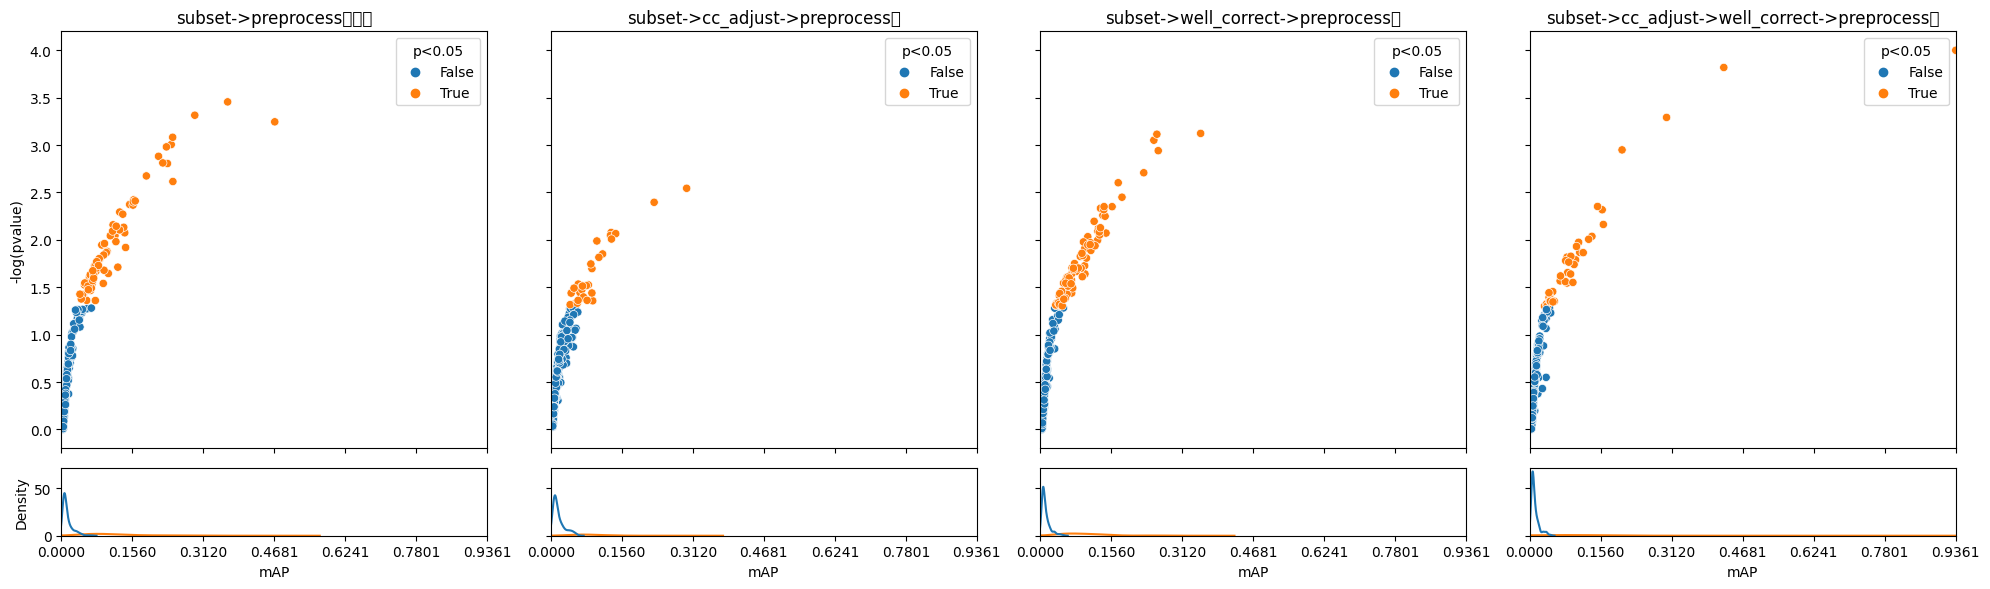

same_well_same_gene subset->preprocess			 mmAP: 0.195 p<0.05: 0.903 (3296/3652)
same_well_same_gene subset->cc_adjust->preprocess	 mmAP: 0.0856 p<0.05: 0.417 (1524/3652)
same_well_same_gene subset->well_correct->preprocess	 mmAP: 0.286 p<0.05: 0.93 (3396/3652)
same_well_same_gene subset->cc_adjust->well_correct->preprocess	 mmAP: 0.538 p<0.05: 0.989 (3611/3652)


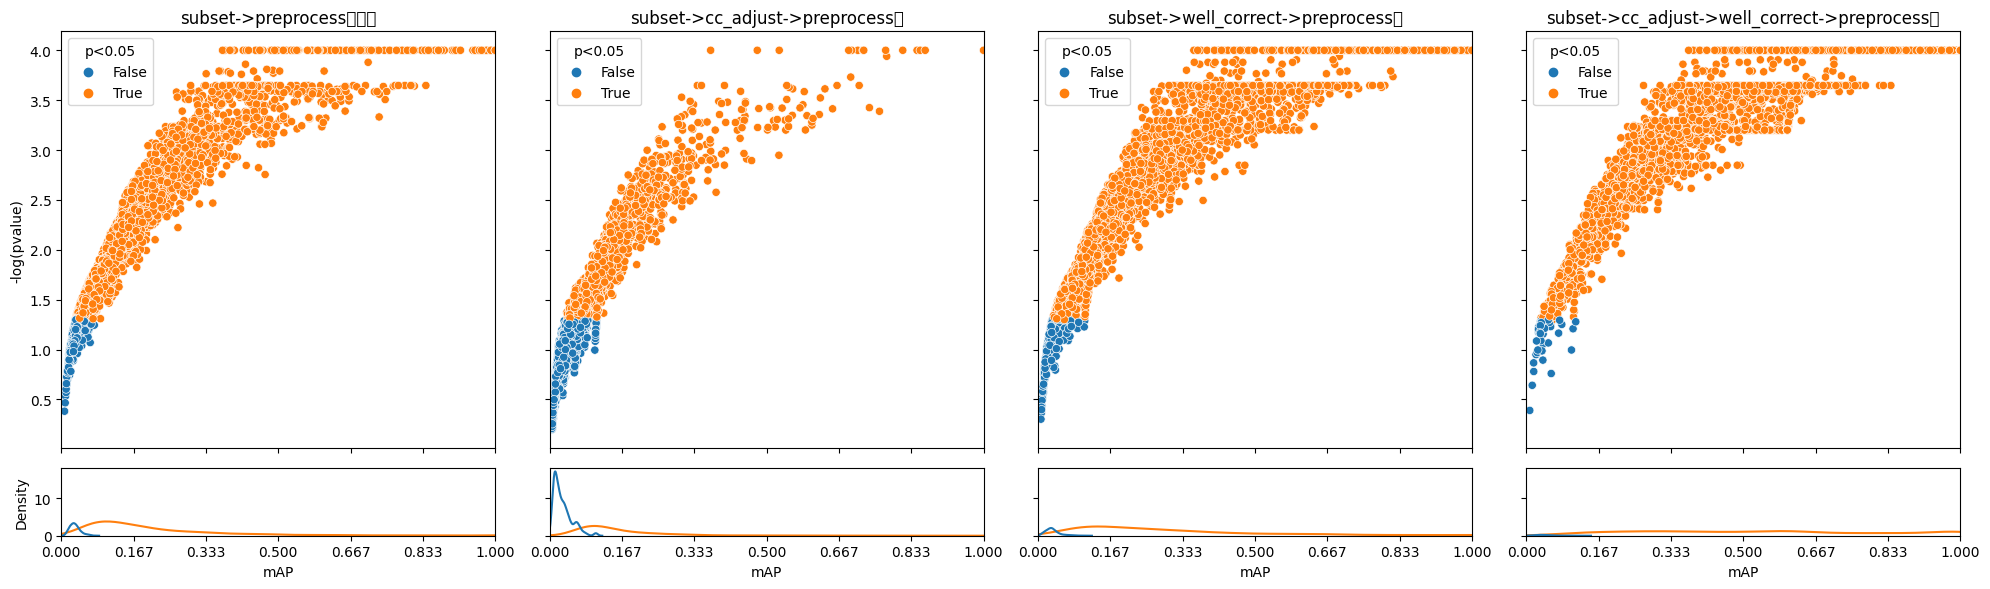

In [7]:
for metrics_df, metrics_label in zip([orf_metrics_df, gene_metrics_df], ["orf", "gene"]):
    for config in metrics_df.config.unique():
        config_df = metrics_df[metrics_df.config==config]
        plot_map_per_config(config_df, config, figsave_path=FIGSAVE_PATH / f"{metrics_label}_cell_count_adjusted")

### Explore relationship between cell count variability and mAP

In [8]:
cell_count_cvar = pd.read_csv("../1.load/output/cell_count_per_orf.csv")
cell_count_cvar

,Metadata_JCP2022,Metadata_Cell_Count_CoV
0,JCP2022_900006,0.052080
1,JCP2022_900008,0.133191
2,JCP2022_900012,0.052447
3,JCP2022_900014,0.084927
4,JCP2022_900015,0.087774
...,...,...
3611,JCP2022_915120,0.098188
3612,JCP2022_915123,0.076138
3613,JCP2022_915125,0.110349
3614,JCP2022_915126,0.052932


#### Merge metrics and cell count CoV on JCP id

The only difference is metrics have `NaNs` due to `same_well_diff_pert`

In [9]:
print("Diff:", set(metrics_df.Metadata_JCP2022.unique()).symmetric_difference(set(cell_count_cvar.Metadata_JCP2022.unique())))

metrics_df = metrics_df.merge(cell_count_cvar, on="Metadata_JCP2022", how="left")
metrics_df.head(3)

AttributeError: 'DataFrame' object has no attribute 'Metadata_JCP2022'

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


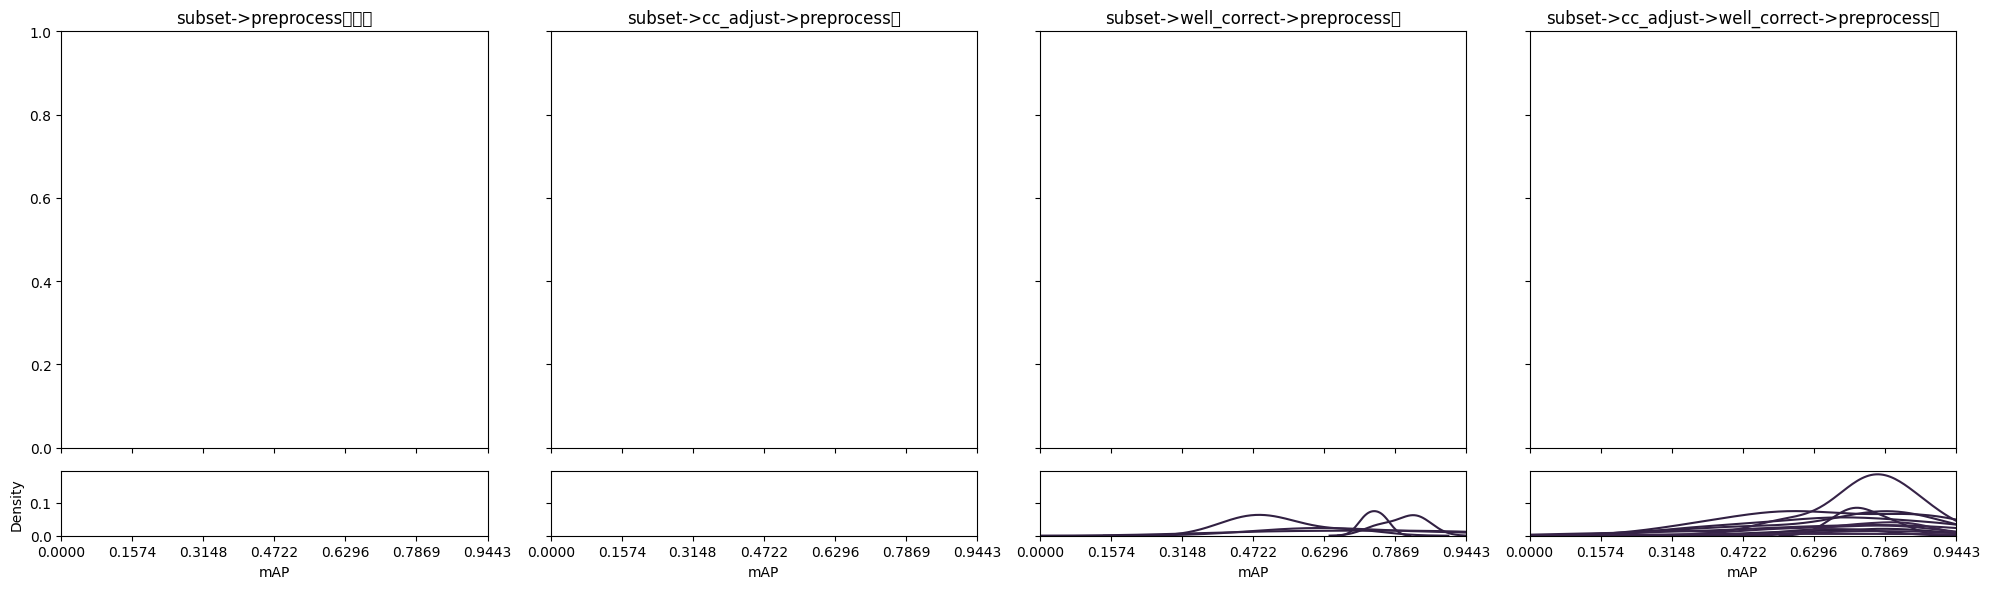

same_pert_diff_well subset->preprocess			 mmAP: 0.00974 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0202 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0166 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00834 p<0.05: 0.0 (0/37)


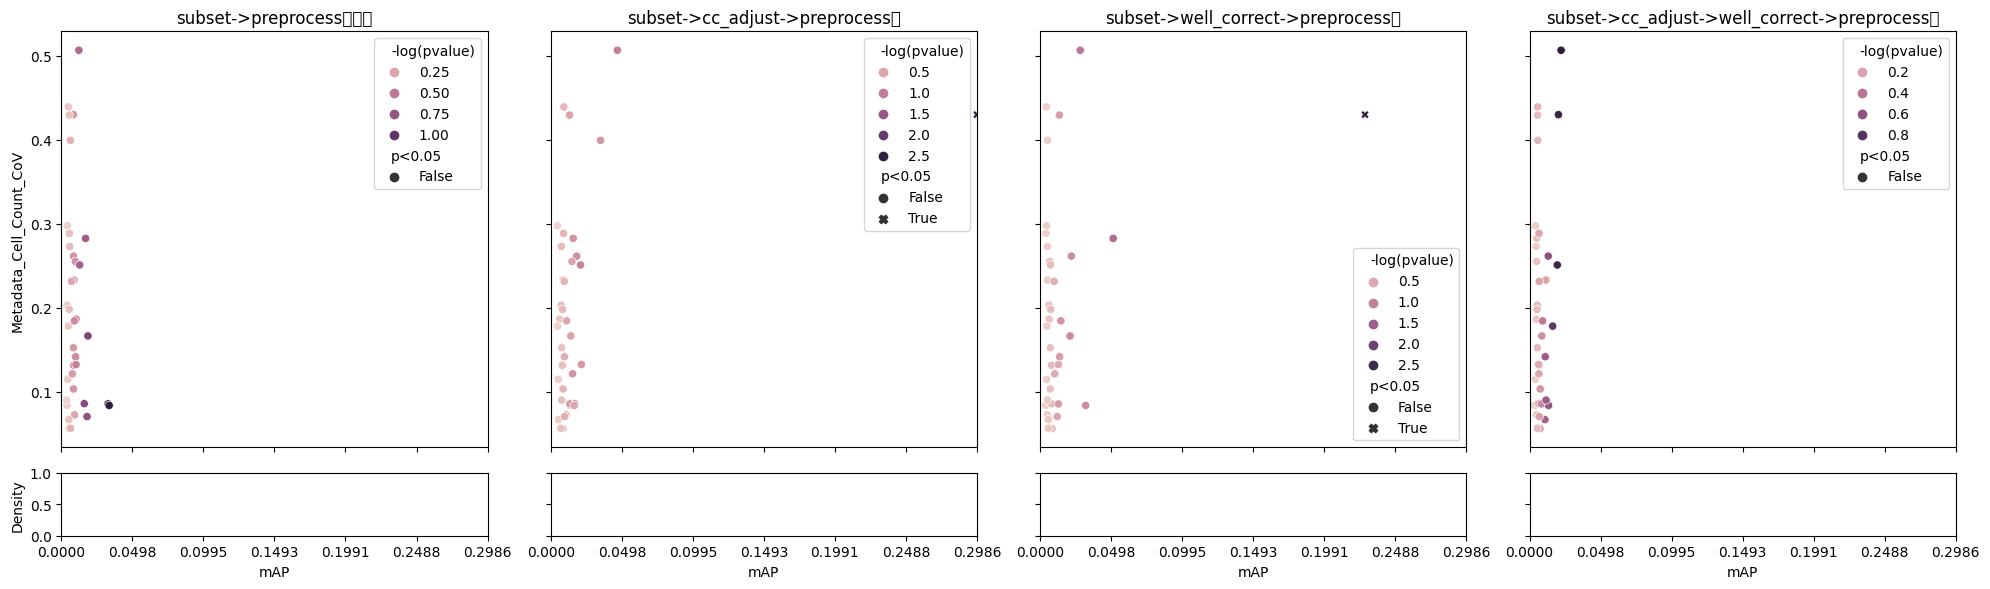

same_well_same_pert subset->preprocess			 mmAP: 0.195 p<0.05: 0.903 (3297/3653)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0856 p<0.05: 0.417 (1524/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.286 p<0.05: 0.93 (3397/3653)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.538 p<0.05: 0.989 (3612/3653)


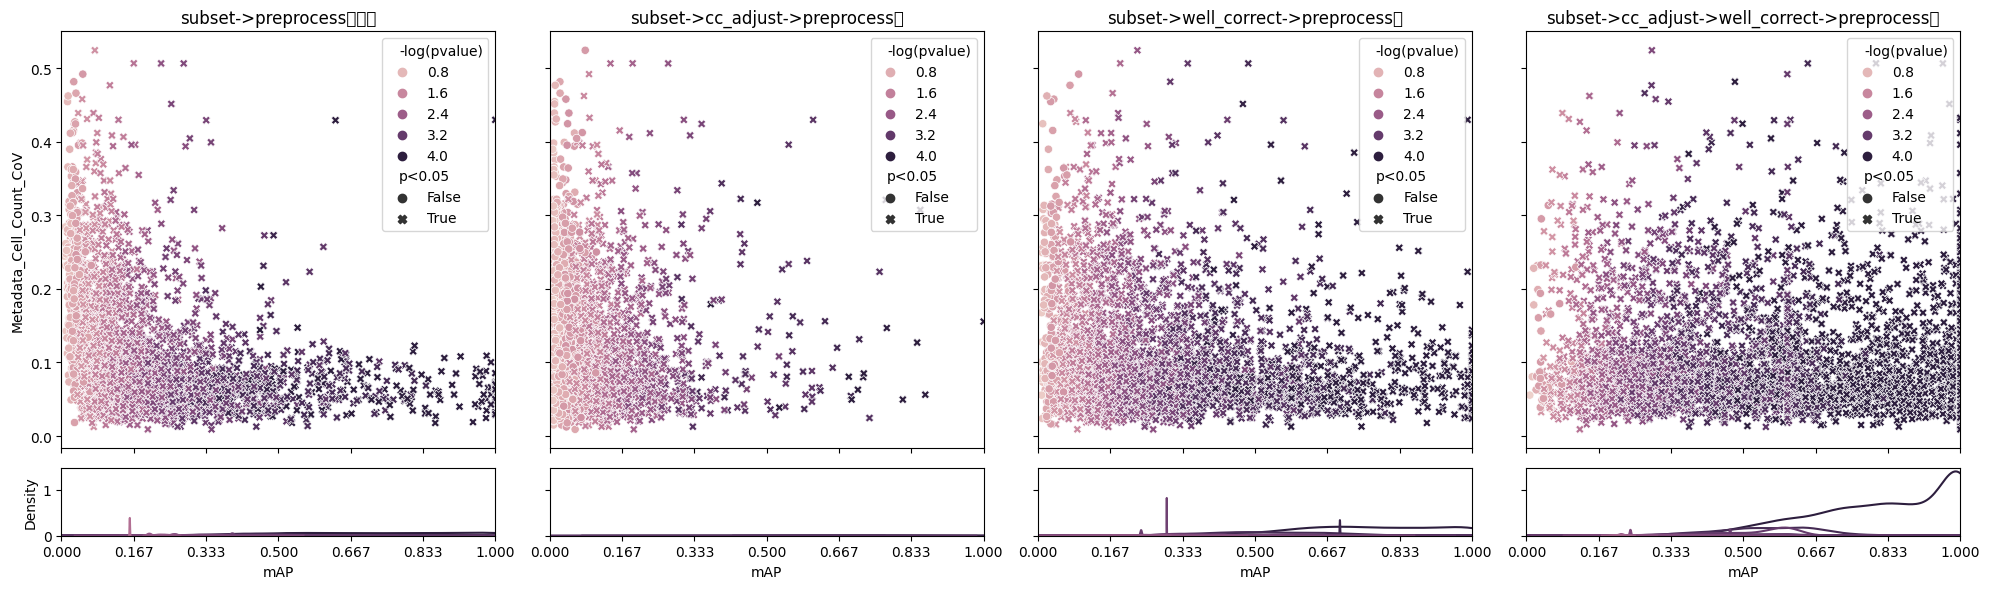

In [ ]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, y_col="Metadata_Cell_Count_CoV",
                        hue_col="-log(pvalue)", style_col="p<0.05",
                         figsave_path=FIGSAVE_PATH / "map_vs_ccv")

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)


ValueError: Axis limits cannot be NaN or Inf

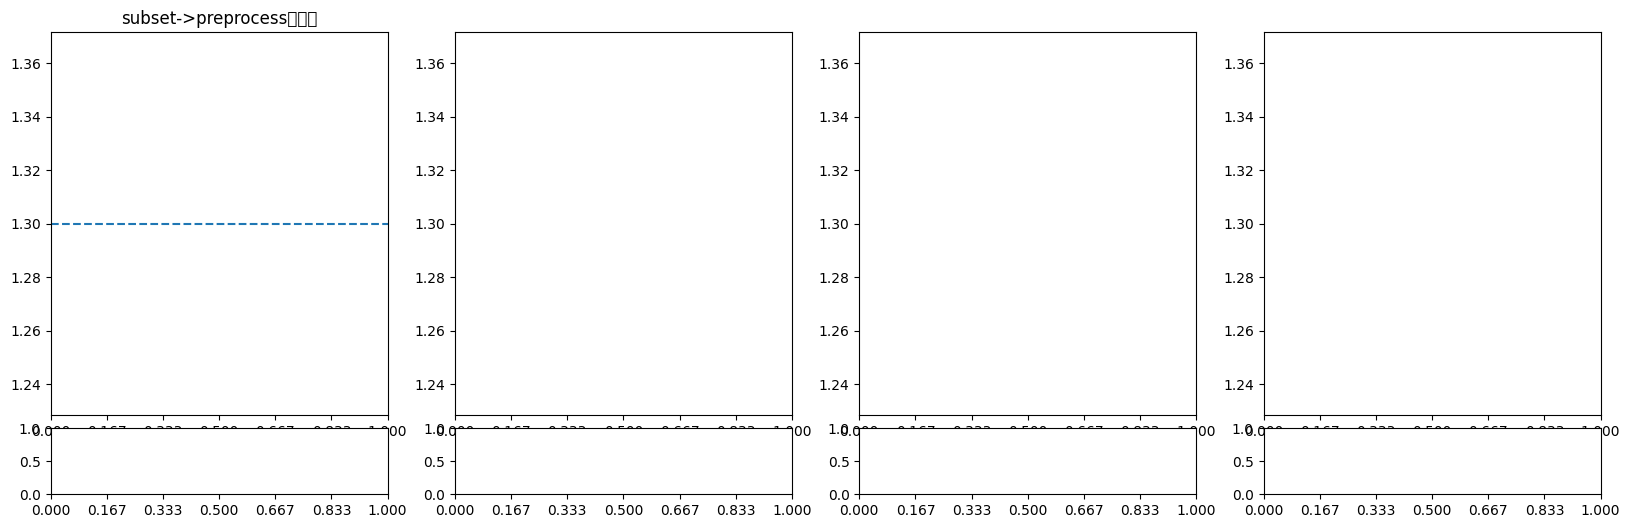

In [ ]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, x_col="Metadata_Cell_Count_CoV", hue_col="mAP", ax_line=1.3,
                        figsave_path=FIGSAVE_PATH / "pvalue_vs_ccv")